In [1]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 kB 3.6 MB/s eta 0:00:00


In [2]:
import FinanceDataReader as fdr

# 삼성전자

In [76]:
# 삼성전자로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('GOOG', '2023-01-01', '2025-12-31') # 005930: 삼성전자, GOOG: 구글
df.tail()

,Open,High,Low,Close,Volume,Adj Close
2025-01-14,192.500000,193.270004,189.639999,191.050003,13651200,191.050003
2025-01-15,194.350006,197.800003,193.330002,196.979996,12894900,196.979996
2025-01-16,195.824997,196.979996,194.300003,194.410004,13449600,194.410004
2025-01-17,198.050003,198.809998,195.309998,197.550003,22109100,197.550003
2025-01-21,200.509995,203.839996,199.440002,199.630005,18967700,199.630005


# 분석 코드

In [77]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
# GPU 꼭 연결해서 사용하세요~!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

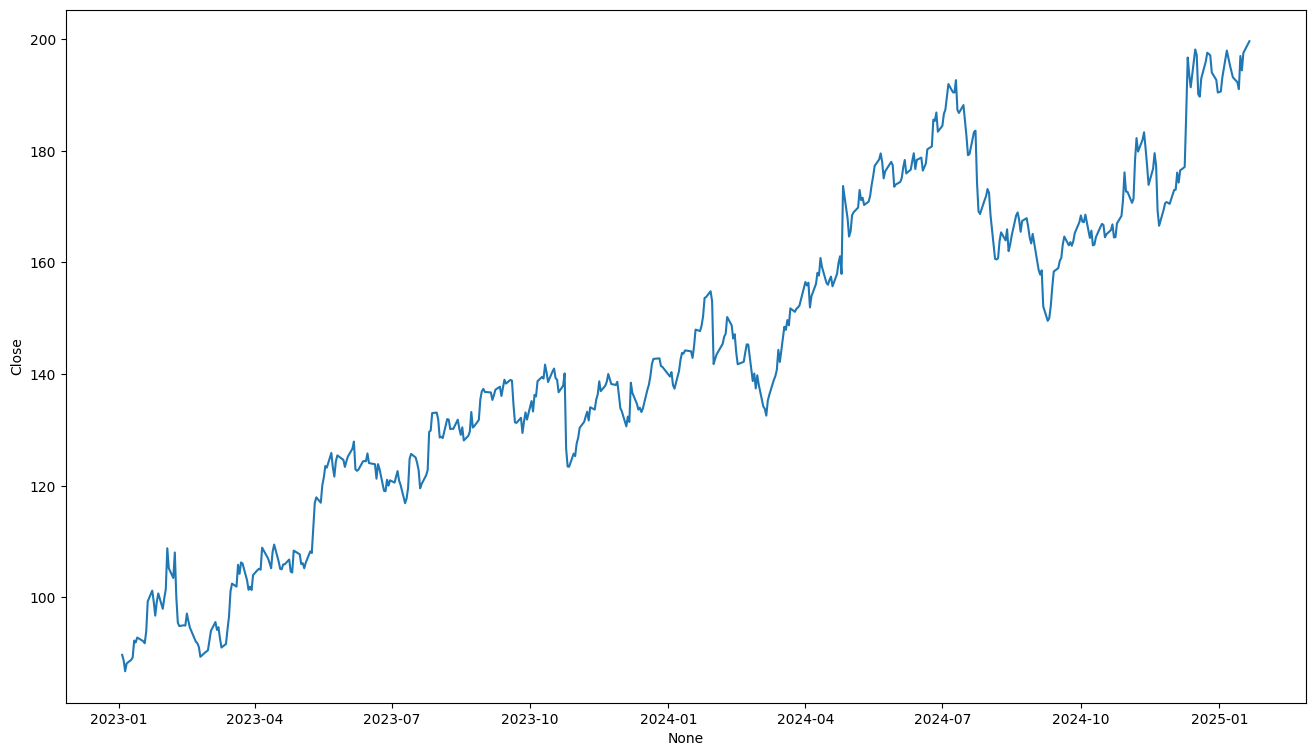

In [79]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()
# 전체적으로는 우상향하고 있으며, 지역적으로 보면 조금씩 상승하다가 급락하는 양상을 보이고 있음.

# 데이터 전처리

In [80]:
#종가 제외 스케일링 (예측변수 = 종가)
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])

In [81]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [84]:
split = 400
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([400, 5, 4]) torch.Size([400, 1])
torch.Size([109, 5, 4]) torch.Size([109, 1])


In [85]:
x_train_seq

tensor([[[0.0273, 0.0289, 0.0303, 0.1531],
         [0.0377, 0.0262, 0.0196, 0.2224],
         [0.0119, 0.0000, 0.0087, 0.1794],
         [0.0056, 0.0022, 0.0000, 0.2176],
         [0.0218, 0.0227, 0.0264, 0.1779]],

        [[0.0377, 0.0262, 0.0196, 0.2224],
         [0.0119, 0.0000, 0.0087, 0.1794],
         [0.0056, 0.0022, 0.0000, 0.2176],
         [0.0218, 0.0227, 0.0264, 0.1779],
         [0.0000, 0.0109, 0.0099, 0.1763]],

        [[0.0119, 0.0000, 0.0087, 0.1794],
         [0.0056, 0.0022, 0.0000, 0.2176],
         [0.0218, 0.0227, 0.0264, 0.1779],
         [0.0000, 0.0109, 0.0099, 0.1763],
         [0.0294, 0.0367, 0.0366, 0.2109]],

        ...,

        [[0.7160, 0.7092, 0.7098, 0.1330],
         [0.6209, 0.6722, 0.6238, 0.3088],
         [0.6523, 0.6412, 0.6372, 0.3224],
         [0.6725, 0.6623, 0.6557, 0.1376],
         [0.6646, 0.6684, 0.6715, 0.0981]],

        [[0.6209, 0.6722, 0.6238, 0.3088],
         [0.6523, 0.6412, 0.6372, 0.3224],
         [0.6725, 0.6623, 0.6557

In [86]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN
## 모델 구축

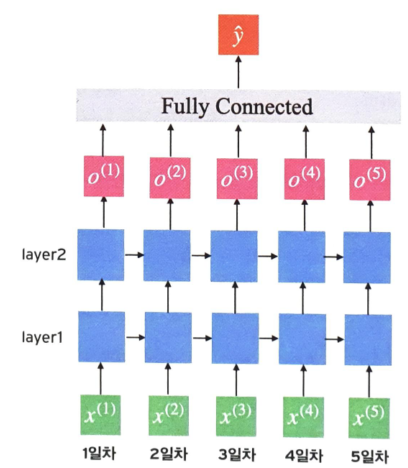

In [87]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [88]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [89]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [90]:
criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 모델 학습

In [91]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0496
[epoch : 10] loss: 0.0018
[epoch : 20] loss: 0.0014
[epoch : 30] loss: 0.0011
[epoch : 40] loss: 0.0010


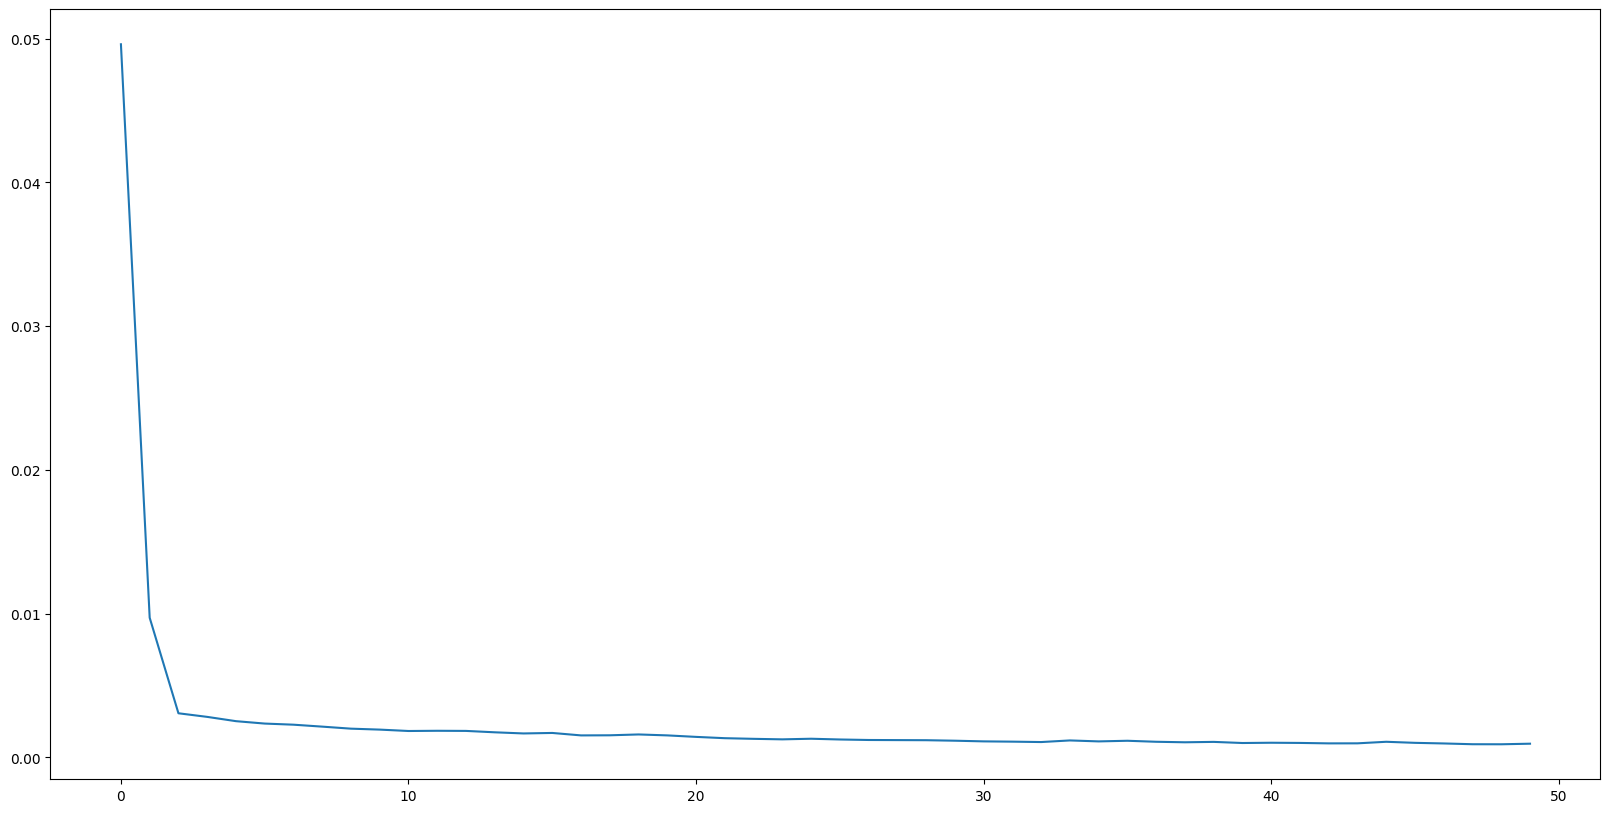

In [92]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## 실제값과 예측값 비교

In [93]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

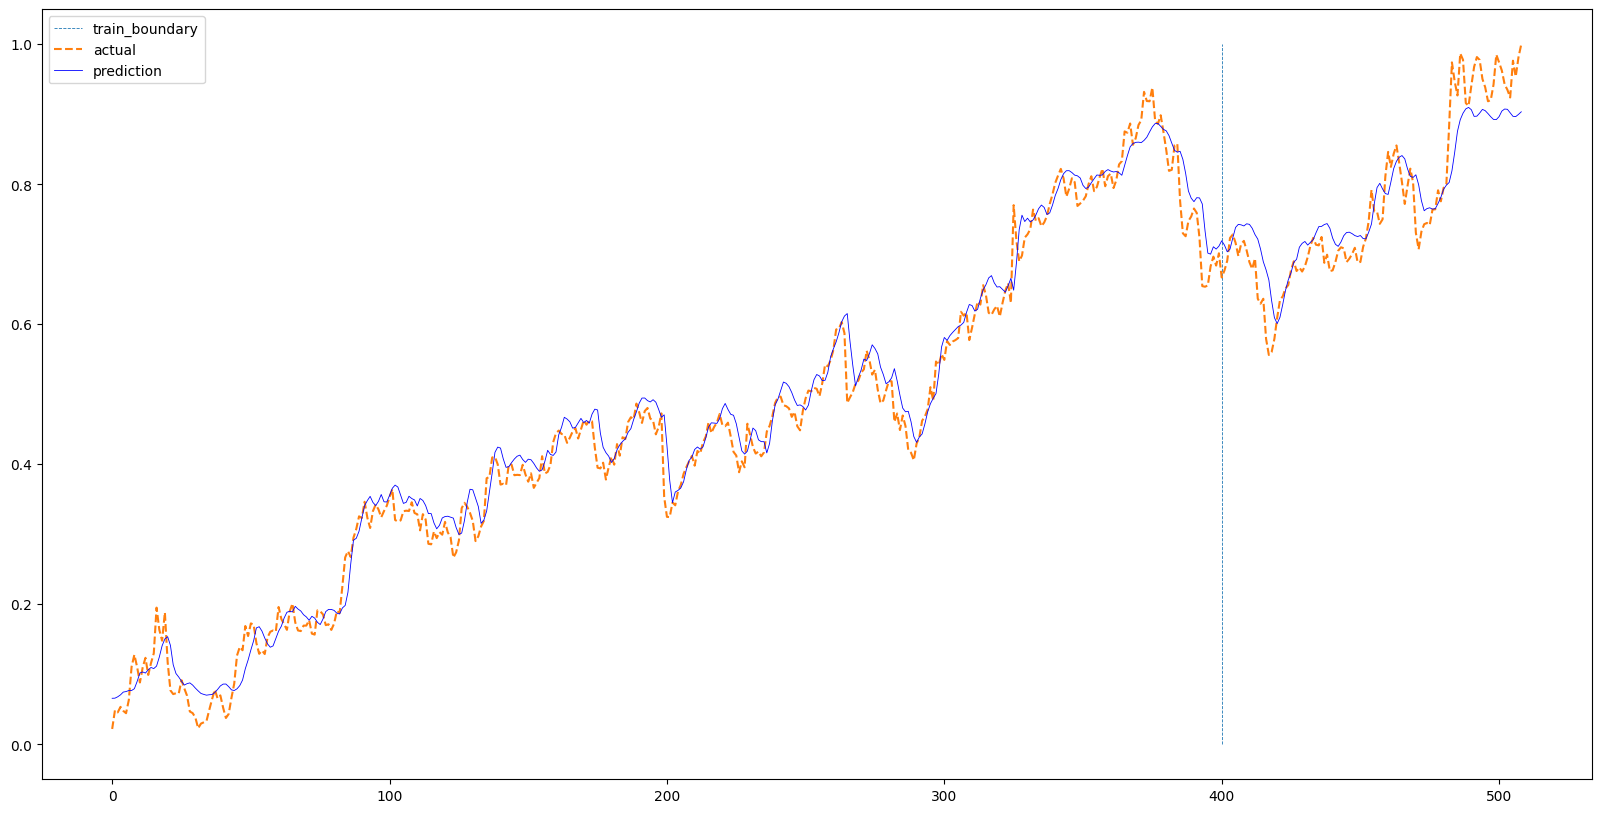

In [94]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# LSTM
## 모델구축

In [95]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [96]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True) # LSTM 모델 정의
    self.fc = nn.Linear(hidden_size*sequence_length ,1) # LSTM 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [97]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [98]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [99]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.1434
[epoch: 10] loss: 0.0015
[epoch: 20] loss: 0.0016
[epoch: 30] loss: 0.0013
[epoch: 40] loss: 0.0015


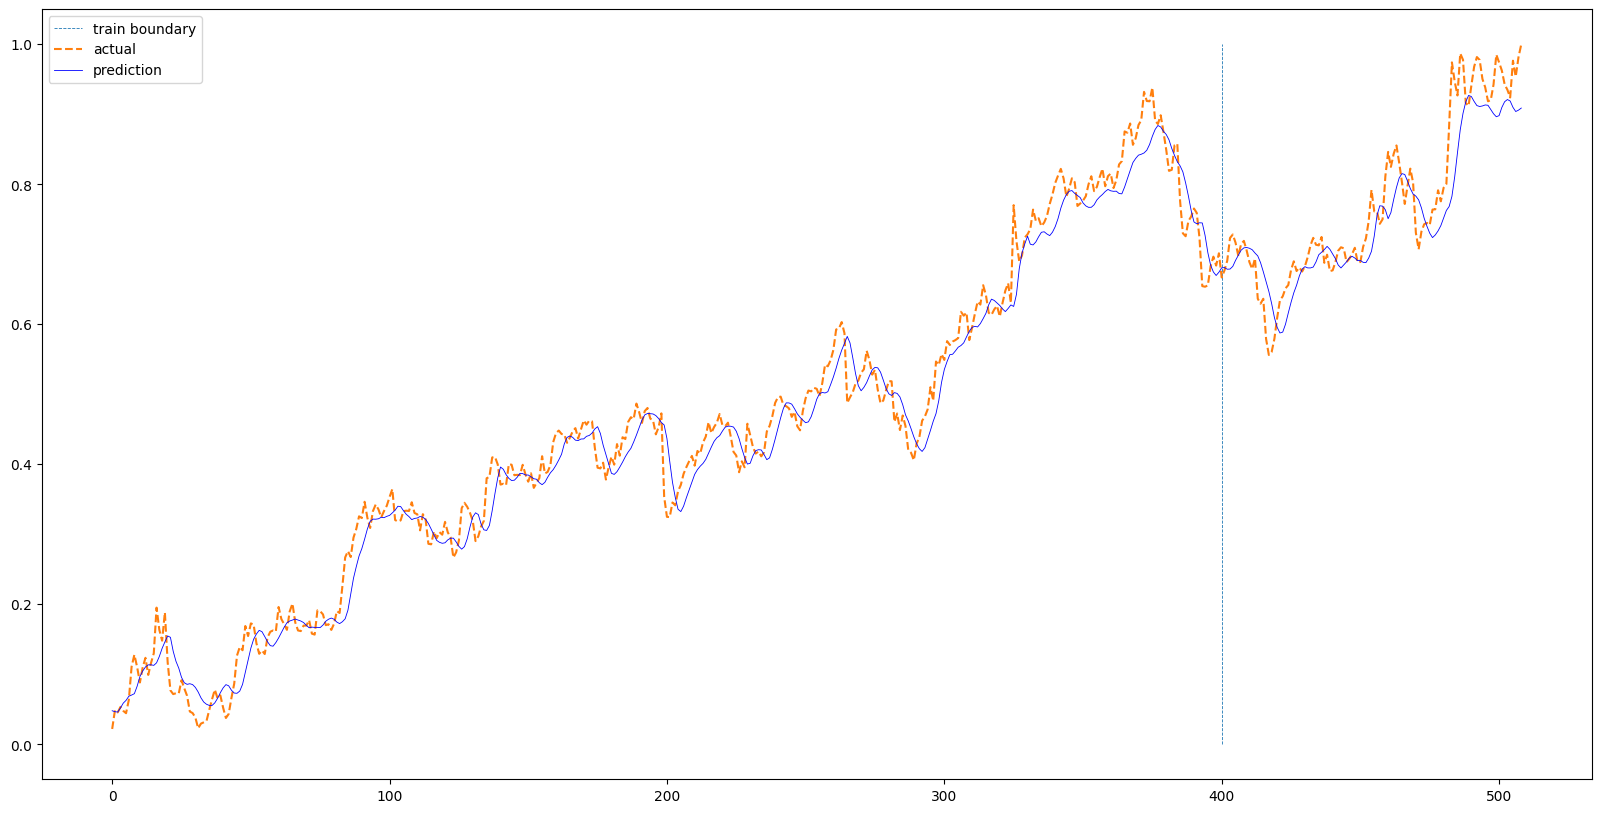

In [100]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

LSTM은 실제 그래프를 우측으로 평행이동 시킨 듯한 예측 그래프가 그려지는 것을 볼 수 있다.
RNN과 LSTM 모두 200까지 학습을 시키고, 나머지를 테스트했을 때는 300 이후 발생하는 peak 값을 제대로 따라가지 못했는데, 400까지 학습을 시키고 나머지를 테스트했을 때는 어느 정도 값과 경향성을 따라가는 것 같다.

# (Optional)

현대 자동차 주가에 대한 정보에 같은 분석을 해봅시다. 다음 코드를 한 번 실행한 뒤, 분석 코드부터 다시 그대로 돌려보시기 보고 결과에 대해 자유롭게 해석해보시기 바랍니다.

In [ ]:
# 현대자동자 주가로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005380', '2024-01-01', '2025-12-31')
df.tail